# Predicting the Probability of Airbnb Prices in NYC

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import os

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share";
from mpl_toolkits.basemap import Basemap
from folium.plugins import HeatMap
import plotly.graph_objs as go

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeClassifier, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix

## Loading Data

In [357]:
df = pd.read_csv('/Users/raylinsoriano/Documents/Flatiron/capstone/data/listings (1).csv')

In [358]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20210901220703,2021-09-02,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20210901220703,2021-09-02,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,4.81,4.72,4.65,NaN,f,1,1,0,0,5.03
2,5121,https://www.airbnb.com/rooms/5121,20210901220703,2021-09-02,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,4.91,4.47,4.52,NaN,f,1,0,1,0,0.54
3,5136,https://www.airbnb.com/rooms/5136,20210901220703,2021-09-02,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,...,5.00,4.50,5.00,NaN,f,1,1,0,0,0.02
4,5178,https://www.airbnb.com/rooms/5178,20210901220703,2021-09-02,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.40,4.86,4.36,NaN,f,1,0,1,0,3.64


In [359]:
df.shape

(36923, 74)

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36923 non-null  int64  
 1   listing_url                                   36923 non-null  object 
 2   scrape_id                                     36923 non-null  int64  
 3   last_scraped                                  36923 non-null  object 
 4   name                                          36910 non-null  object 
 5   description                                   35710 non-null  object 
 6   neighborhood_overview                         22510 non-null  object 
 7   picture_url                                   36923 non-null  object 
 8   host_id                                       36923 non-null  int64  
 9   host_url                                      36923 non-null 

In [361]:
pd.options.display.max_rows = 4000

In [362]:

df.duplicated().sum()

0

In [363]:
df.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               13
description                                      1213
neighborhood_overview                           14413
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                         111
host_since                                        111
host_location                                     209
host_about                                      15287
host_response_time                              15743
host_response_rate                              15743
host_acceptance_rate                            15102
host_is_superhost                                 111
host_thumbnail_url          

### Cleaning Data

In [364]:
df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

0         19.0
1         86.0
2          NaN
3         33.0
4        100.0
         ...  
36918     96.0
36919     25.0
36920     78.0
36921     25.0
36922    100.0
Name: host_acceptance_rate, Length: 36923, dtype: float64

In [365]:
# Created a column for how many years the airbnb has been a host
df['host_since'] = pd.to_datetime(df['host_since'])
df['year'] = df['host_since'].apply(lambda date: date.year)

df['years_been_host'] = max(df['year']) - df['year']

In [366]:
#Created a column of how many verifications each host has
df['number_of_verifications'] = df.host_verifications.str.count(',')+1

In [367]:
#Created a column of how many amenities each host has
df['number_of_amenities'] = df.amenities.str.count(',')+1

In [368]:
df['bathrooms_text'] = df.bathrooms_text.str.extract('(\d+)').astype(float)


In [369]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


In [370]:
median = df.filter(['host_listings_count','beds', 'bedrooms'
                    ,'accommodates','years_been_host','bathrooms_text']).median()

In [371]:
cols = ['host_listings_count','beds', 'bedrooms','accommodates','years_been_host','bathrooms_text']                          
df[cols]=df[cols].fillna(median)

In [372]:
mean = df.filter(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value']).mean()

In [373]:
cols2 = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location','review_scores_value']                          
df[cols2]=df[cols2].fillna(mean)

In [374]:
df = df.fillna(df.mode().iloc[0])

In [375]:
df["last_scraped"].value_counts()

2021-09-02    32883
2021-09-03     2629
2021-09-01     1293
2021-09-06      118
Name: last_scraped, dtype: int64

In [376]:
df['calendar_last_scraped'].value_counts()

2021-09-02    32912
2021-09-03     2600
2021-09-01     1293
2021-09-06      118
Name: calendar_last_scraped, dtype: int64

In [377]:
df['host_since'].min()

Timestamp('2008-08-22 00:00:00')

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            36923 non-null  int64         
 1   listing_url                                   36923 non-null  object        
 2   scrape_id                                     36923 non-null  int64         
 3   last_scraped                                  36923 non-null  object        
 4   name                                          36923 non-null  object        
 5   description                                   36923 non-null  object        
 6   neighborhood_overview                         36923 non-null  object        
 7   picture_url                                   36923 non-null  object        
 8   host_id                                       36923 non-null  int6

### Graphs

In [379]:
# set the filepath and load in a shapefile
fp = '/Users/raylinsoriano/Documents/Flatiron/capstone/data/Borough Boundaries.zip'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.187194e+09,463868.937681,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,1.0,Manhattan,6.365759e+08,359804.890798,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,5.0,Staten Island,1.623636e+09,325929.794027,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
3,3.0,Brooklyn,1.934174e+09,728195.197649,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.040205e+09,900270.512975,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


<AxesSubplot:>

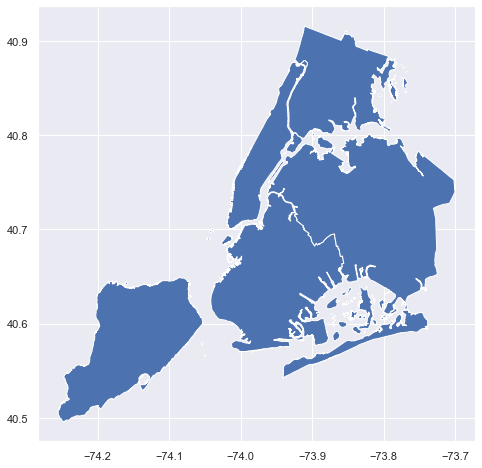

In [380]:
map_df.plot()

In [381]:
# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('neighbourhood_group_cleansed').size())
#borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('neighbourhood_group_cleansed').price.median().values
borough_df['median_rating'] = df.groupby('neighbourhood_group_cleansed').review_scores_rating.median().values
# Joining the dataframes
borough_map_df = map_df.set_index('boro_name').join(borough_df)

borough_map_df.head()

,boro_code,shape_area,shape_leng,geometry,0,median_price,median_rating
boro_name,,,,,,,
Bronx,2.0,1.187194e+09,463868.937681,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",1026,75.0,4.70
Manhattan,1.0,6.365759e+08,359804.890798,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",16242,146.0,4.59
Staten Island,5.0,1.623636e+09,325929.794027,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",313,90.0,4.80
Brooklyn,3.0,1.934174e+09,728195.197649,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...",14392,99.0,4.74
Queens,4.0,3.040205e+09,900270.512975,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",4950,75.0,4.67


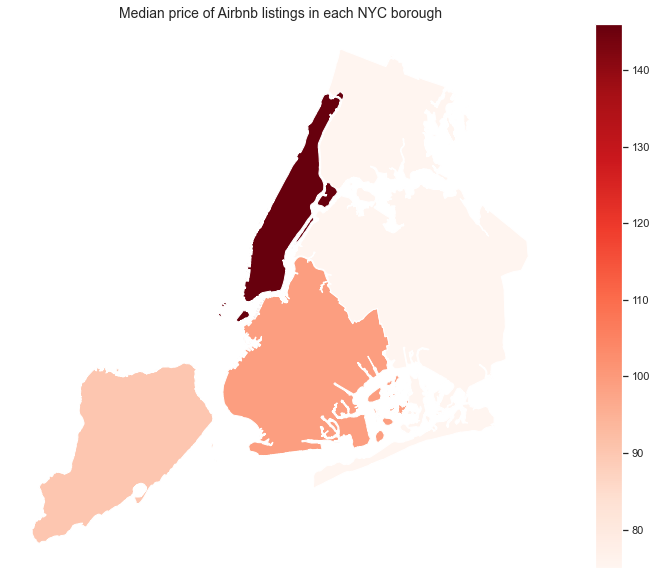

In [382]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 10))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)

ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each NYC borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


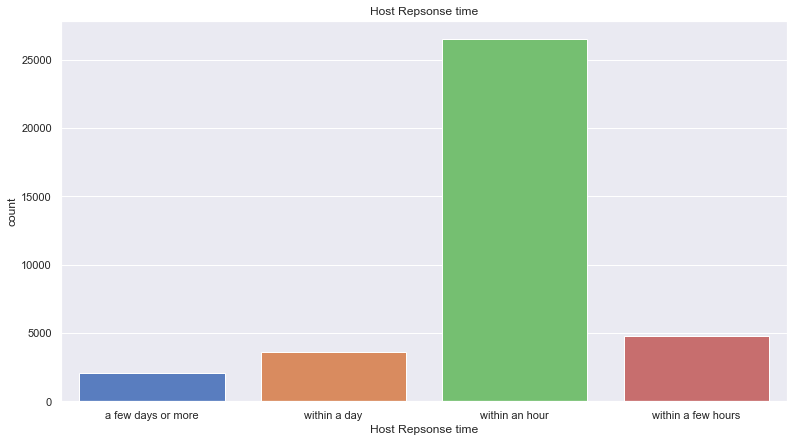

In [383]:
plt.figure(figsize=(13,7))
plt.title("Host Repsonse time")
host_response_time_graph = sns.countplot(df.host_response_time, palette="muted")
host_response_time_graph.set_xlabel("Host Repsonse time")
fig = plt.gcf()
plt.show()


In [384]:
attractions = pd.read_csv('/Users/raylinsoriano/Documents/Flatiron/capstone/data/cultural-institutions-by-block-and-lot.csv')

In [385]:
attractions.shape

(70, 15)

In [386]:
attractions = attractions.dropna()

In [387]:
attractions.isna().sum()

Organization Name                                               0
Preferred Address Line 1                                        0
Preferred Block-Lot Number                                      0
Constituency Code                                               0
Constituent Specific Attributes R-Secondary Type Description    0
Borough                                                         0
Postcode                                                        0
Latitude                                                        0
Longitude                                                       0
Community Board                                                 0
Council District                                                0
Census Tract                                                    0
BIN                                                             0
BBL                                                             0
NTA                                                             0
dtype: int

In [388]:
 attractions['Latitude'].iloc[0]

40.715781

In [389]:
lng1 = attractions['Longitude'].iloc[0]

In [390]:
attractions

,Organization Name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...
8,Trinity Church,74 Trinity Place,51-1,Retail Space,C-Religious Institutions,Manhattan,10006.0,40.708387,-74.012563,1.0,1.0,13.0,1001036.0,1.000510e+09,Battery Park City-Lower Manhattan ...
10,Museum of American Finance,48 Wall Street,40-1,Retail Space,A-Museums & Performing Arts,Manhattan,10005.0,40.706331,-74.009396,1.0,1.0,7.0,1001005.0,1.000400e+09,Battery Park City-Lower Manhattan ...
11,Bodies The Exhibition,11 Fulton Street,96-1,Cultural Institution,A-Museums & Performing Arts,Manhattan,10038.0,40.706639,-74.003477,1.0,1.0,1501.0,1001318.0,1.000960e+09,Battery Park City-Lower Manhattan ...
12,Bodies The Exhibition,11 Fulton Street,96-1,Retail Space,A-Museums & Performing Arts,Manhattan,10038.0,40.706639,-74.003477,1.0,1.0,1501.0,1001318.0,1.000960e+09,Battery Park City-Lower Manhattan ...
14,The Skyscraper Museum,39 Battery Place,16-7513,Retail Space,A-Museums & Performing Arts,Manhattan,10280.0,40.705869,-74.017994,1.0,1.0,31704.0,1085789.0,1.000168e+09,Battery Park City-Lower Manhattan ...


In [391]:
lng2= df['longitude'].iloc[0]

In [392]:
lat2 = df['latitude'].iloc[0]

In [393]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [394]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [395]:
#haversine_array(lat1, lng1, lat2, lng2)

In [396]:
#dummy_manhattan_distance(lat1, lng1, lat2, lng2)

In [397]:
crs = {'init': 'epsg:4326'}
geo = [Point(xy) for xy in zip( df['longitude'], df['latitude'])]
print(geo[:3])





geo_df = gpd.GeoDataFrame(df, crs=crs,  geometry=geo )
geo_df = geo_df[geo_df['longitude'] != 0.0]

[<shapely.geometry.point.Point object at 0x7fa3491fdb80>, <shapely.geometry.point.Point object at 0x7fa3570118e0>, <shapely.geometry.point.Point object at 0x7fa302ae6280>]


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [398]:
# fig, ax = plt.subplots(figsize = (18,18))
# map_df.plot(ax = ax, alpha = 0.4, color = 'grey')
# geo_df[geo_df['MOST_SEVERE_INJURY'] == 'severe'].plot(ax = ax, 
#                                                         markersize = 10, 
#                                                         color = 'blue', 
#                                                         marker = 'o', 
#                                                         label = 'severe')


In [399]:
#Created a column for how many years the airbnb has been a host
df['host_since'] = pd.to_datetime(df['host_since'])
df['year'] = df['host_since'].apply(lambda date: date.year)

df['years_been_host'] = max(df['year']) - df['year']

In [400]:
#Distance from time sqaure
df['distance_ts'] = dummy_manhattan_distance(df['latitude'], df['longitude'], lat2=40.7580, lng2=73.9855)

In [401]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            36923 non-null  int64         
 1   listing_url                                   36923 non-null  object        
 2   scrape_id                                     36923 non-null  int64         
 3   last_scraped                                  36923 non-null  object        
 4   name                                          36923 non-null  object        
 5   description                                   36923 non-null  object        
 6   neighborhood_overview                         36923 non-null  object        
 7   picture_url                                   36923 non-null  object        
 8   host_id                                       36923 non-null  int6

In [402]:
pd.options.display.max_rows =4000

In [403]:
#df['distance_ts'].value_counts()

In [404]:

attractions_geo = gpd.GeoDataFrame(attractions, 
                                   geometry=gpd.points_from_xy(attractions.Longitude, attractions.Latitude))






In [405]:
attractions_geo

,Organization Name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01652 40.71578)
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572)
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572)
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01380 40.70751)
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01329 40.70240)
8,Trinity Church,74 Trinity Place,51-1,Retail Space,C-Religious Institutions,Manhattan,10006.0,40.708387,-74.012563,1.0,1.0,13.0,1001036.0,1.000510e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01256 40.70839)
10,Museum of American Finance,48 Wall Street,40-1,Retail Space,A-Museums & Performing Arts,Manhattan,10005.0,40.706331,-74.009396,1.0,1.0,7.0,1001005.0,1.000400e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00940 40.70633)
11,Bodies The Exhibition,11 Fulton Street,96-1,Cultural Institution,A-Museums & Performing Arts,Manhattan,10038.0,40.706639,-74.003477,1.0,1.0,1501.0,1001318.0,1.000960e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00348 40.70664)
12,Bodies The Exhibition,11 Fulton Street,96-1,Retail Space,A-Museums & Performing Arts,Manhattan,10038.0,40.706639,-74.003477,1.0,1.0,1501.0,1001318.0,1.000960e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00348 40.70664)
14,The Skyscraper Museum,39 Battery Place,16-7513,Retail Space,A-Museums & Performing Arts,Manhattan,10280.0,40.705869,-74.017994,1.0,1.0,31704.0,1085789.0,1.000168e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01799 40.70587)


<AxesSubplot:>

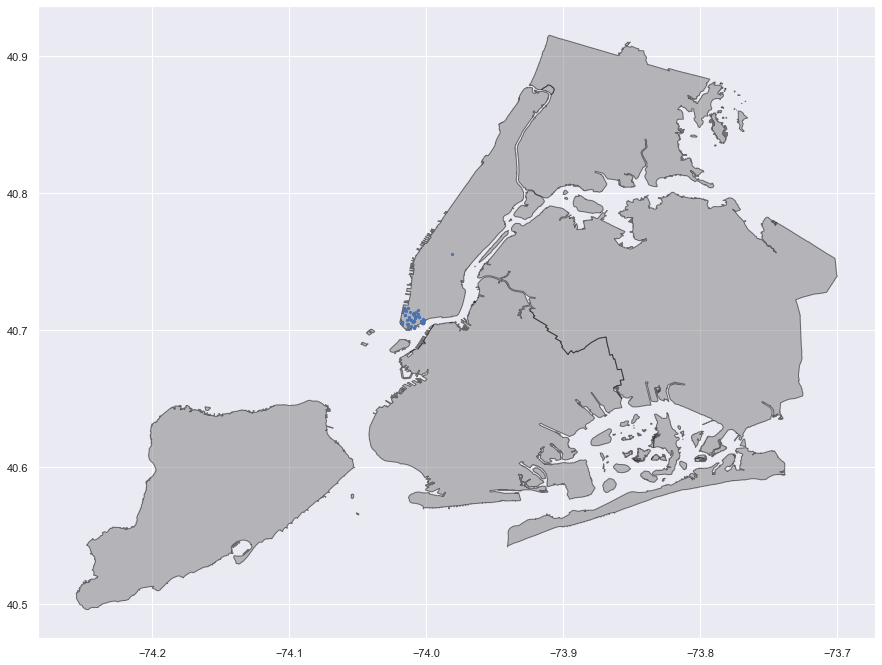

In [406]:

fig,ax1 = plt.subplots(1,1, figsize=(15,15))
base = map_df.plot(color='grey',alpha=0.5, edgecolor='black', ax=ax1)
attractions_geo.plot(markersize=5,ax=base)

In [407]:
fp2 = '/Users/raylinsoriano/Documents/Flatiron/capstone/data/Individual Landmark Sites'
map_df2 = gpd.read_file(fp2)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df2.head()

,address,bbl,block,borough,date_des_d,time_des_d,landmark_t,lot,lpc_altern,lpc_lpnumb,lpc_name,lpc_site_d,lpc_site_s,objectid,objectid_1,shape_area,shape_leng,url_report,geometry
0,105 Franklin Avenue,5.000580e+09,58.0,SI,1970-10-13,00:00:00.000,Individual Landmark,27.0,also known as Hamilton Park Cottage,LP-00330,105 Franklin Avenue House,"Borough of Richmond Tax Map Block 58, Lot 27.",Designated,1.0,1.0,11078.250002,446.281129,http://s-media.nyc.gov/agencies/lpc/lp/0330.pdf,"POLYGON ((-74.09145 40.64303, -74.09142 40.642..."
1,435 Richmond Hill Road,5.023900e+09,2390.0,SI,1967-12-13,00:00:00.000,Individual Landmark,194.0,None,LP-00369,Decker Farmhouse,"Borough of Richmond Tax Map Block 2390, Lot 194.",Designated,2.0,2.0,484779.747763,2797.209417,http://s-media.nyc.gov/agencies/lpc/lp/0369.pdf,"POLYGON ((-74.15192 40.58296, -74.15200 40.582..."
2,98 Grant Street,5.005060e+09,506.0,SI,1996-11-19,00:00:00.000,Individual Landmark,81.0,None,LP-01877,Public School 15 (Daniel D. Tompkins School),"Borough of Staten Island Tax Map Block 506, Lo...",Designated,3.0,3.0,32265.596414,748.859029,http://s-media.nyc.gov/agencies/lpc/lp/1877.pdf,"POLYGON ((-74.07791 40.63379, -74.07805 40.633..."
3,121 Heberton Avenue,5.010150e+09,1015.0,SI,2002-12-17,00:00:00.000,Individual Landmark,9.0,None,LP-02120,121 Heberton Avenue House,Borough of the Staten Island Tax Map Block 101...,Designated,4.0,4.0,6515.861133,329.167837,http://s-media.nyc.gov/agencies/lpc/lp/2120.pdf,"POLYGON ((-74.13067 40.63717, -74.13072 40.636..."
4,3531 Richmond Road,5.022810e+09,2281.0,SI,1967-08-24,00:00:00.000,Individual Landmark,155.0,also known as the Moore-McMillen House,LP-00366,Reverend David Moore House,"Borough of Richmond Tax Map Block 2282, Lot 155.",Designated,5.0,5.0,34036.911836,775.778936,http://s-media.nyc.gov/agencies/lpc/lp/0366.pdf,"POLYGON ((-74.13863 40.57340, -74.13829 40.572..."


<AxesSubplot:>

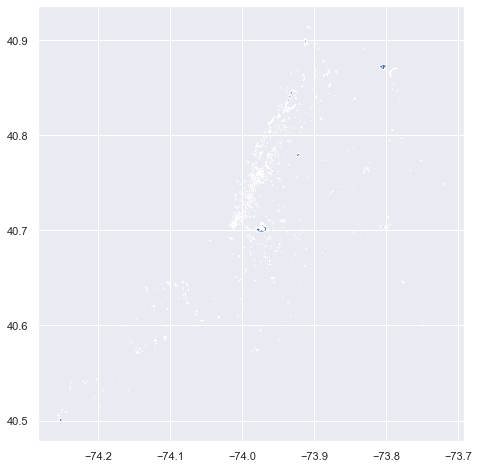

In [408]:
map_df2.plot()

In [409]:
poi = pd.read_csv('/Users/raylinsoriano/Documents/Flatiron/capstone/data/Point_Of_Interest.csv')

In [410]:
#poi.head(10)

In [411]:
geo_df2 = gpd.read_file('/Users/raylinsoriano/Documents/Flatiron/capstone/data/attraction_polygon.geojson')

In [412]:
geo_df2.shape

(67, 123)

In [413]:
pd.options.display.max_rows =4000

In [414]:
geo_df2

,tourism,name,building,wikidata,wikipedia,historic,start_date,layer,website,addr:housenumber,...,shop,short_name:de,short_name:es,short_name:fr,sport,sub_sea,team,team_2,train,geometry
0,attraction,Abyssinian Baptist Church,yes,Q49254,None,None,None,None,None,132,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-73.94179 40.81662, -73.94149 40.816..."
1,attraction,Aermacchi MB339 PAN,yes,None,None,aircraft,None,3,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-74.00122 40.76502, -74.00119 40.765..."
2,attraction,Amazen' Maze,None,None,None,None,None,None,https://www.adventuresgovisland.com/,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-74.02106 40.68999, -74.02091 40.689..."
3,attraction,Ambrose,None,Q7890707,en:United States lightship Ambrose (LV-87),ship,1907,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-74.00262 40.70545, -74.00262 40.705..."
4,attraction,Blackwell House,yes,Q4923596,en:Blackwell House,yes,None,None,None,500,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-73.95125 40.76028, -73.95119 40.760..."
5,attraction,Bow Bridge,None,Q4950616,en:Bow Bridge (Central Park),None,None,1,https://www.centralpark.com/things-to-do/attra...,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-73.97193 40.77592, -73.97166 40.775..."
6,attraction,Brooklyn Bridge,None,Q125006,en:Brooklyn Bridge,None,None,3,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-74.00436 40.71193, -74.00288 40.710..."
7,attraction,Bryant Park,None,Q995174,en:Bryant Park,None,None,None,http://www.bryantpark.org,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-73.98480 40.75357, -73.98310 40.752..."
8,attraction,Castle Clinton,yes,Q1049423,en:Castle Clinton,yes,None,None,None,10,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-74.01713 40.70345, -74.01713 40.703..."
9,attraction,Cathedral of Saint John the Divine,yes,Q865655,en:Cathedral of Saint John the Divine,None,None,None,https://www.stjohndivine.org/,1047,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-73.96279 40.80391, -73.96278 40.803..."


In [415]:
df.shape

(36923, 80)

In [416]:
attractions.head()

,Organization Name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01652 40.71578)
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572)
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572)
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01380 40.70751)
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01329 40.70240)


In [417]:
attractions.rename(columns={"Organization Name": "organization_name"}, inplace=True)

In [418]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [419]:
# concatenating lat and long to create a consolidated location as accepted by havesine function
attractions['coor'] = list(zip(attractions.Latitude, attractions.Longitude))
df['coor'] = list(zip(df.latitude, df.longitude))

In [420]:
attractions.head()

,organization_name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry,coor
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01652 40.71578),"(40.715781, -74.016518)"
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572),"(40.705717, -74.002453)"
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,POINT (-74.00245 40.70572),"(40.705717, -74.002453)"
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01380 40.70751),"(40.707514, -74.0138)"
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...,POINT (-74.01329 40.70240),"(40.702398, -74.013287)"


In [421]:
import pandas as pd
import numpy as np
import haversine as hs
import folium

In [422]:
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [423]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,year,years_been_host,number_of_verifications,number_of_amenities,geometry,distance_ts,coor
0,2595,https://www.airbnb.com/rooms/2595,20210901220703,2021-09-02,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,0,0,0.33,2008,13,9,31,POINT (-73.98559 40.75356),10392.674145,"(40.75356, -73.98559)"
1,3831,https://www.airbnb.com/rooms/3831,20210901220703,2021-09-02,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,0,0,5.03,2008,13,6,35,POINT (-73.95765 40.68494),10413.322858,"(40.68494, -73.95765)"
2,5121,https://www.airbnb.com/rooms/5121,20210901220703,2021-09-02,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,The Greenpoint House in only a few short block...,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,1,0,0.54,2009,12,8,5,POINT (-73.95512 40.68535),10413.107801,"(40.68535, -73.95512)"
3,5136,https://www.airbnb.com/rooms/5136,20210901220703,2021-09-02,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,The Greenpoint House in only a few short block...,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,...,0,0,0.02,2009,12,3,14,POINT (-73.99454 40.66265),10421.591992,"(40.66265, -73.99454)"
4,5178,https://www.airbnb.com/rooms/5178,20210901220703,2021-09-02,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,1,0,3.64,2009,12,4,19,POINT (-73.98317 40.76457),10390.587498,"(40.76457, -73.98317)"


In [424]:
`

SyntaxError: invalid syntax (473536216.py, line 1)

In [425]:
# running a loop which will parse customers location one by one to distance from function 
for _,row in attractions.iterrows():
    df[row.organization_name]= df['coor'].apply(lambda x: distance_from(row.coor,x))

In [426]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       ...
       'Tribute WTC', 'Center for Castle Garden Immigration',
       'Wall Street Synagogue', 'Manhattan By Sail', 'Poets House',
       'South Street Seaport Museum', 'Cannon's Walk',
       'The River Vineyard Christian Fellowship', 'Bike & Roll Bike Rentals',
       'NY Waterway Tours'],
      dtype='object', length=124)

In [300]:
def create_map(df,attractions):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=12, tiles='OpenStreetMap')
    
   
    
    for _, row in df.iterrows():
         
        if row['Condition']=='Out':
            cluster_colour='blue'
        else:
            cluster_colour = 'green'
        
        folium.CircleMarker(
            location= [row['latitude'],row['longitude']],
            radius=5,
            popup= row[['Condition','id']],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
            ).add_to(m)
    
    for _, row in attractions.iterrows(): 
        folium.Marker(
            location= [row['Latitude'],row['Longitude']],
            radius=5,
            popup= row['Organization Name'],
            color='red',
            fill=True,
            fill_color='red'
             ).add_to(m)
    for _, row in attractions.iterrows(): 
        folium.Circle(
            location= [row['Latitude'],row['Longitude']],
            radius=100,
            popup= row['Organization Name'],
            color='black',
            fill=False,
        ).add_to(m)
        
    return m

In [249]:
#hotel_list=[60,61]

In [250]:
# df['Condition']='Out'

# for i in hotel_list:
#     df['Condition'][df.Condition=='Out']=df[df.Condition=='Out'][i].apply(lambda x: 'In' if x<3 else 'Out')


In [302]:
# m= create_map(df,attractions)
# m

In [303]:
#df['Condition']

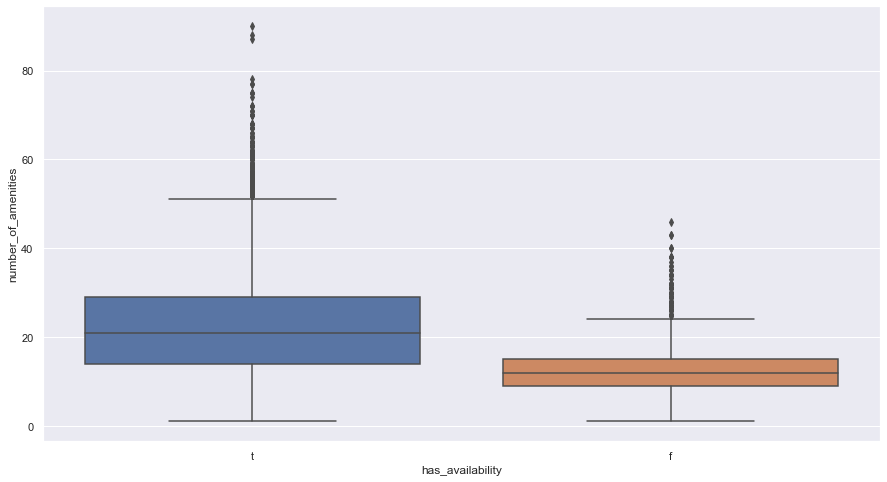

In [427]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="has_availability", y="number_of_amenities", data=df)


In [428]:
df['amenities']

0        ["Free street parking", "Heating", "TV", "Dedi...
1        ["Dedicated workspace", "Iron", "Stove", "Hair...
2        ["Kitchen", "Long term stays allowed", "Air co...
3        ["Dryer", "BBQ grill", "Kitchen", "Long term s...
4        ["Hot water", "Bed linens", "Extra pillows and...
                               ...                        
36918    ["Dedicated workspace", "Essentials", "Microwa...
36919    ["Heating", "TV", "Freezer", "Toaster", "Trash...
36920    ["Dedicated workspace", "Stove", "Washer", "Ha...
36921    ["Heating", "TV", "Freezer", "Toaster", "Trash...
36922    ["Kitchen", "Washer", "Smoke alarm", "Heating"...
Name: amenities, Length: 36923, dtype: object

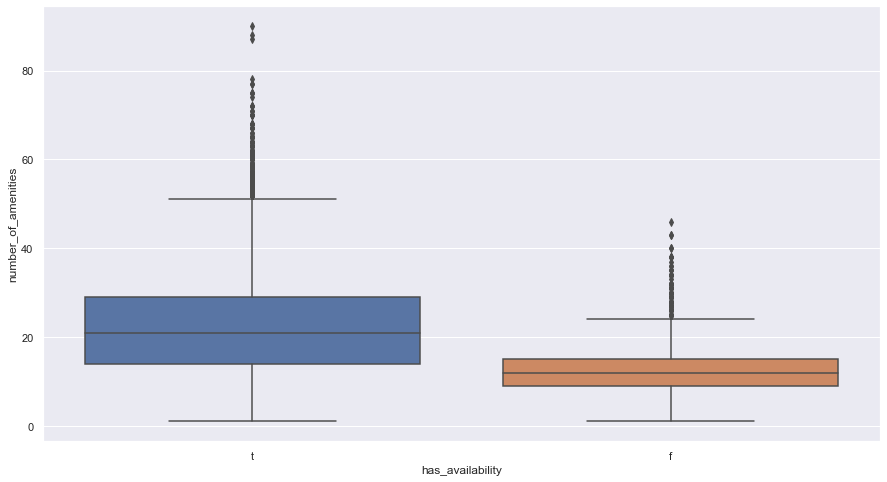

In [429]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="has_availability", y="number_of_amenities", data=df)


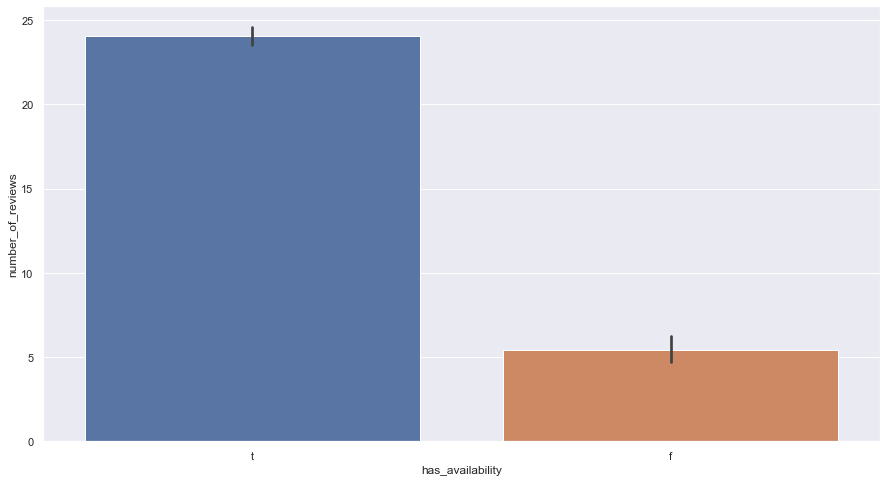

In [473]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x="has_availability", y="number_of_reviews", data=df)


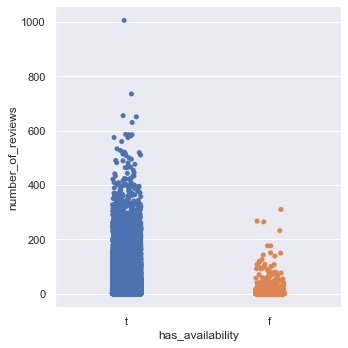

In [431]:
sns.set(rc = {'figure.figsize':(10,8)})
ax2 = sns.catplot(x="has_availability", y="number_of_reviews", data=df)


In [432]:
# counter = []
# for x in df['instant_bookable']:
#     if x == 't':
#         counter[x+1]

In [433]:
df.instant_bookable.value_counts()

f    27063
t     9860
Name: instant_bookable, dtype: int64

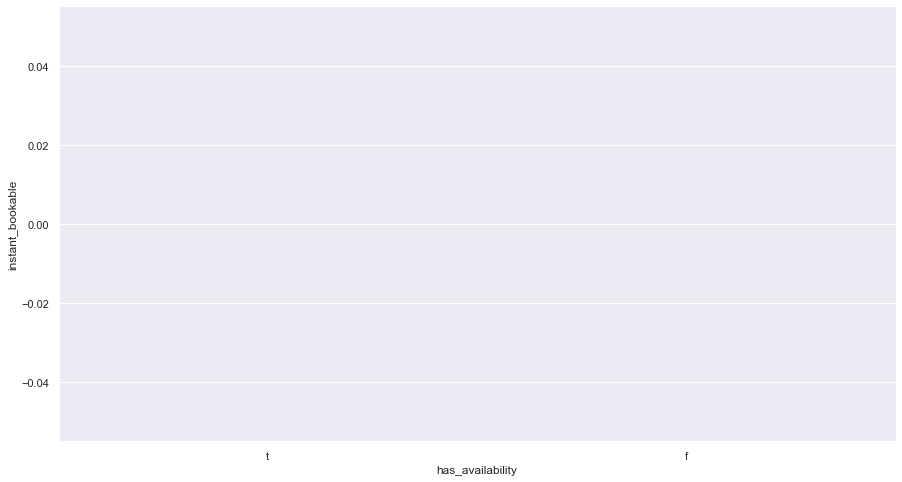

In [434]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x="has_availability", y=df.instant_bookable.value_counts(), data=df)


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


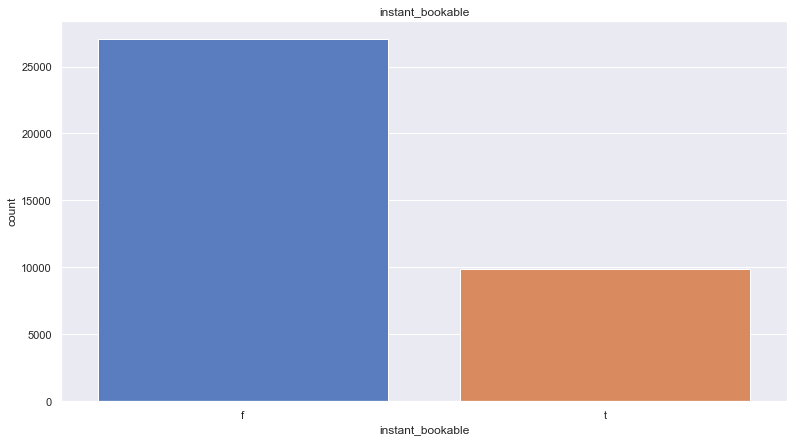

In [435]:
plt.figure(figsize=(13,7))
plt.title("instant_bookable")
host_response_time_graph = sns.countplot(df.instant_bookable, palette="muted")
host_response_time_graph.set_xlabel("instant_bookable")
fig = plt.gcf()
plt.show()


In [436]:
df['instant_bookable']

0        f
1        f
2        f
3        f
4        f
        ..
36918    t
36919    f
36920    f
36921    f
36922    f
Name: instant_bookable, Length: 36923, dtype: object

In [437]:
fake_df = pd.get_dummies(df,columns=['instant_bookable'])

In [438]:
fake_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       ...
       'Wall Street Synagogue', 'Manhattan By Sail', 'Poets House',
       'South Street Seaport Museum', 'Cannon's Walk',
       'The River Vineyard Christian Fellowship', 'Bike & Roll Bike Rentals',
       'NY Waterway Tours', 'instant_bookable_f', 'instant_bookable_t'],
      dtype='object', length=125)

In [439]:
fake_df["instant_bookable_f"].sum()

27063

In [440]:
df['instant_bookable'] == 't'

0        False
1        False
2        False
3        False
4        False
         ...  
36918     True
36919    False
36920    False
36921    False
36922    False
Name: instant_bookable, Length: 36923, dtype: bool

In [441]:
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x="has_availability", y=df.instant_bookable, data=df)


In [466]:
fake_df.instant_bookable_f

0        1
1        1
2        1
3        1
4        1
        ..
36918    0
36919    1
36920    1
36921    1
36922    1
Name: instant_bookable_f, Length: 36923, dtype: uint8

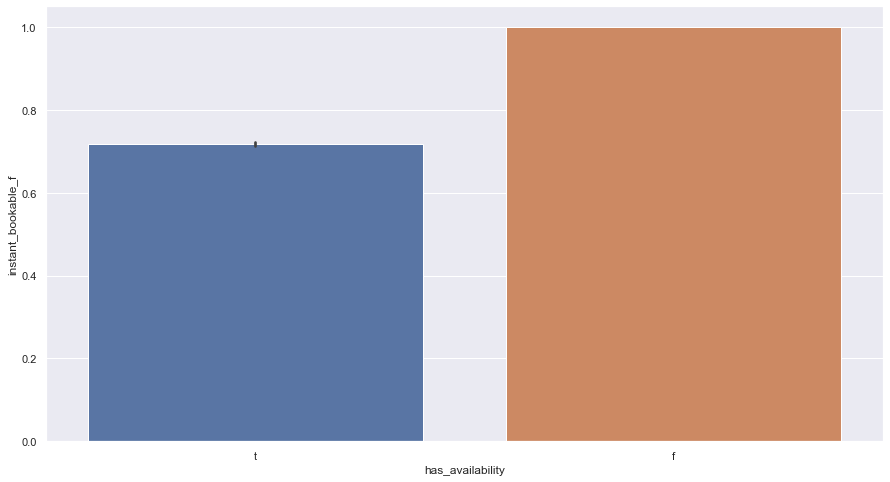

In [465]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x="has_availability", y=fake_df.instant_bookable_f, data=fake_df)


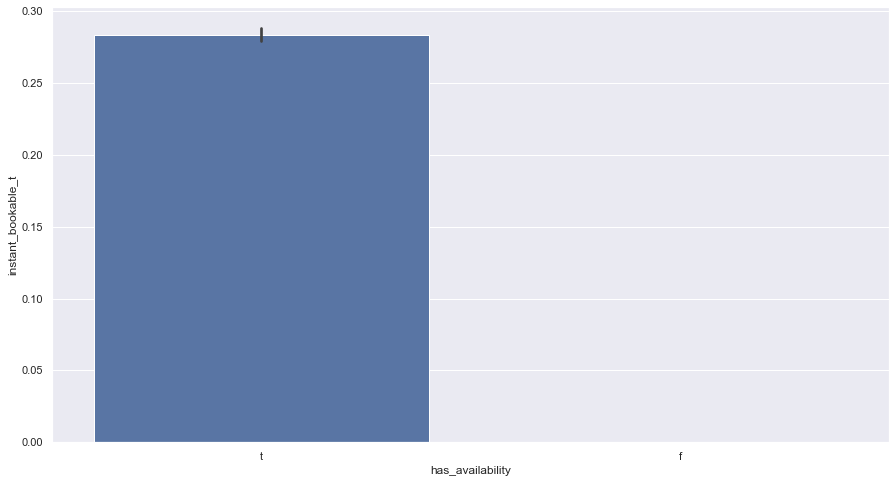

In [443]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x="has_availability", y=fake_df.instant_bookable_t, data=fake_df)


In [444]:
#ok = df.groupby('has_availability',axis=1).instant_bookable.agg(lambda g: g.eq('f').sum())

In [445]:
ok

has_availability
f     2132
t    24931
Name: instant_bookable, dtype: int64

In [446]:
okkk = pd.get_dummies(df, columns=['instant_bookable']).groupby('has_availability').sum()

In [450]:
okkk.reset_index()

,has_availability,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,...,Wall Street Synagogue,Manhattan By Sail,Poets House,South Street Seaport Museum,Cannon's Walk,The River Vineyard Christian Fellowship,Bike & Roll Bike Rentals,NY Waterway Tours,instant_bookable_f,instant_bookable_t
0,f,31922584528,43089641402538800,105778823437,2605.0,2605.0,8.683991e+04,-1.576746e+05,4528,0.0,...,15281.24,15322.87,16237.58,15352.68,15292.00,15802.51,15322.87,17070.61,2132.0,0.0
1,t,994173125148,703157464369478016,3860946981643,1203814.0,1203814.0,1.417009e+06,-2.572765e+06,98767,0.0,...,271279.01,271213.02,287772.33,271854.26,270918.43,280314.41,271213.02,299883.68,24931.0,9860.0


In [448]:
pp = pd.crosstab(fake_df.has_availability, fake_df.instant_bookable_f).reset_index()

<BarContainer object of 2 artists>

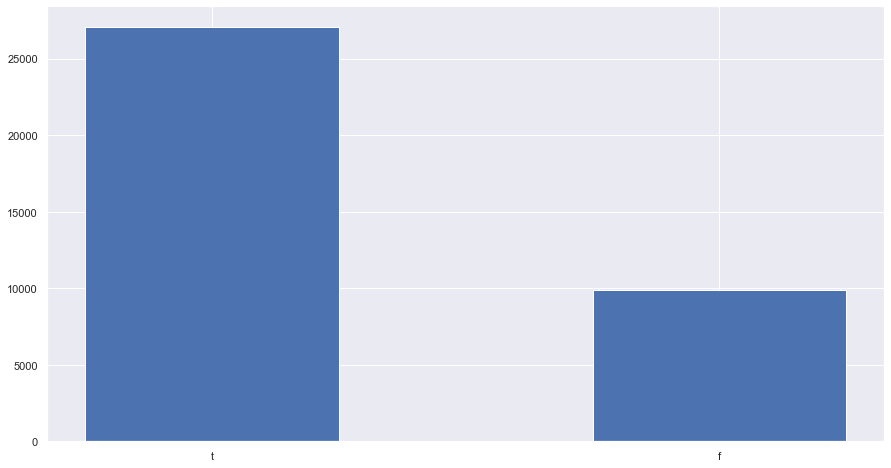

In [461]:
categories = fake_df['has_availability'].value_counts().index
counts = fake_df['instant_bookable_t'].value_counts().values
plt.bar(categories, counts, width=0.5);


In [ ]:
categories = df['has_availability'].value_counts().index
counts = fake_df['instant_bookable_t'].value_counts().values
plt.bar(categories, counts, width=0.5)


In [157]:
df = df.drop(['host_url','listing_url', 'picture_url','host_thumbnail_url', 'host_picture_url','neighbourhood'
              ,'host_neighbourhood','property_type','bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights'
             ,'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm'
             ,'calendar_updated','calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d'
             ,'first_review','last_review', 'review_scores_value','license','reviews_per_month', 'neighborhood_overview'
             ,'host_response_rate', 'host_acceptance_rate','host_about', 'host_location', 'scrape_id','last_scraped'
             ,'host_since','year', 'neighbourhood_cleansed', 'amenities','host_name', 'name', 'host_id', 'description'
             ,'geometry', 'coor'
             
             ], axis=1)

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Columns: 142 entries, id to NY Waterway Tours
dtypes: float64(115), int64(17), object(10)
memory usage: 40.0+ MB


In [159]:
df.isna().sum()

id                                              0
host_response_time                              0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_group_cleansed                    0
latitude                                        0
longitude                                       0
room_type                                       0
accommodates                                    0
bathrooms_text                                  0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
has_availability                                0


In [160]:
df['has_availability'].value_counts()

t    34791
f     2132
Name: has_availability, dtype: int64

In [161]:
df['has_availability'].value_counts(normalize=True)

t    0.942258
f    0.057742
Name: has_availability, dtype: float64

In [172]:
df['has_availability'] = df['has_availability'].map({'t': 0,
                                     'f': 1,})


In [173]:
X= df.drop(["has_availability",'id', 'latitude','longitude'],axis=1)
y= df["has_availability"]

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y)

In [174]:
#Categorical variables to use
categorical_vars = ["host_response_time","host_has_profile_pic","host_identity_verified","host_is_superhost"
            ,"neighbourhood_group_cleansed","room_type","instant_bookable", "Condition"]

In [175]:
train = X_train[categorical_vars]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')
enc = ohe.fit(train)
train_dummies_trans = enc.transform(train)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categorical_vars)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names,index = X_train.index)

In [176]:
test = X_test[categorical_vars]
    
# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')
enc = ohe.fit(test)
test_dummies_trans = enc.transform(test)

# Dummies values in matrix form
test_data = test_dummies_trans.todense()

# New dummy column names
names1 = ohe.get_feature_names(categorical_vars)

# Make them into Dataframe
test_dummies_trans_df = pd.DataFrame(test_data, columns=names1,index = X_test.index)

In [177]:
numerical = (X_train.select_dtypes(exclude='object'))
numerical = pd.DataFrame(numerical, index = X_train.index)
df_train = train_dummies_trans_df.merge(numerical, left_index = True , right_index=True)

In [178]:
numerical1 = (X_test.select_dtypes(exclude='object'))
numerical1 = pd.DataFrame(numerical1, index = X_test.index)
df_test = test_dummies_trans_df.merge(numerical1, left_index = True , right_index=True)

In [179]:

df_train.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,host_is_superhost_f,host_is_superhost_t,...,60,61,62,63,64,65,66,67,68,69
24282,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,4.83,6.47,6.47,6.47,4.97,4.97,5.96,6.38,4.83,5.84
18640,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,6.86,8.35,8.35,8.35,6.97,6.96,7.87,8.27,6.86,8.03
32591,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,6.20,5.54,5.54,5.54,6.13,6.08,5.65,5.54,6.20,6.73
1015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,4.06,3.10,3.10,3.10,3.96,3.92,3.29,3.11,4.06,4.35
14189,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,24.67,24.33,24.33,24.33,24.63,24.58,24.37,24.32,24.67,25.45


In [180]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and class target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision', 'recall', 'f1']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring, cv=5)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print('Cross_Val Accuracy', results['train_accuracy'].mean())
    print('##############')
    print('Training Precision:', results['train_precision'].mean())
    print('##############')
    print('Training  Recall:', results['train_recall'].mean())
    print('##############')
    print('Training  F1:', results['train_f1'].mean())

In [181]:
fsm_pip = Pipeline([('nb', MultinomialNB())
                    ])

fsm_pip.fit(df_train, y_train)

Pipeline(steps=[('nb', MultinomialNB())])

In [182]:
print_cv_scores(fsm_pip, df_train, y_train)

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.9423103  0.62000632 0.94222262 0.94226776 0.94226776]
Training Accuracy 0.8778149527545025
##############
Cross_Val Accuracy 0.8778149527545025
##############
Training Precision: 0.5263032930731908
##############
Training  Recall: 0.19984350566849102
##############
Training  F1: 0.04771993466614066


## log

In [184]:
log_pipe = Pipeline([('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])
log_pipe.fit(df_train,  y_train)


Pipeline(steps=[('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [185]:
print_cv_scores(log_pipe, df_train, y_train)

[0.94167833 0.94321311 0.94208721 0.94208721 0.94208721]
Training Accuracy 0.9422306120017769
##############
Cross_Val Accuracy 0.9422306120017769
##############
Training Precision: 0.41319679126130743
##############
Training  Recall: 0.012196295934323687
##############
Training  F1: 0.02330699193099959


## Log and scaled

In [186]:
log_pipe_scale = Pipeline([('ss', StandardScaler() ),
                           ('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])
log_pipe_scale.fit(df_train,  y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [187]:
print_cv_scores(log_pipe_scale, df_train, y_train)


[0.94434162 0.94425134 0.94384761 0.94411844 0.94425386]
Training Accuracy 0.9441625764463941
##############
Cross_Val Accuracy 0.9441625764463941
##############
Training Precision: 0.6280452468112099
##############
Training  Recall: 0.08098978694292416
##############
Training  F1: 0.14339848352082993


In [188]:
grid = {'lg__class_weight': [None,'balanced'], 
         'lg__tol': [0.0001, 0.01, 0.1],
         'lg__C' : [0.0001,0.001,0.01],
         'lg__penalty': ['l1', 'l2']
        }

In [189]:
gridsearch = GridSearchCV(log_pipe_scale, grid, return_train_score=True, scoring='precision',verbose=2)

gridsearch.fit(df_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.1; total time=   0.6s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.1; total time=   0.4s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.0001; total time=   2.0s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.0001; total time=   1.7s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.0001; total time=   2.1s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.0001; total time=   0.5s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.0001; total time=   0.9s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l2, lg__tol=0.01; total time=   0.3s
[

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.8s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.9s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.5s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.6s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.9s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.7s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.4s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.6s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.4s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.4s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.4s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.4s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.8s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   1.3s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.4s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.6s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.4s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.3s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.6s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.6s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.6s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.8s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.6s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.8s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.9s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, l

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lg',
                                        LogisticRegression(max_iter=100000000,
                                                           solver='liblinear'))]),
             param_grid={'lg__C': [0.0001, 0.001, 0.01],
                         'lg__class_weight': [None, 'balanced'],
                         'lg__penalty': ['l1', 'l2'],
                         'lg__tol': [0.0001, 0.01, 0.1]},
             return_train_score=True, scoring='precision', verbose=2)

In [190]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'lg__C': 0.0001, 'lg__class_weight': None, 'lg__penalty': 'l2', 'lg__tol': 0.0001}
gridsearch best score: 0.6


In [191]:
log_pipe2 = Pipeline([('lg', LogisticRegression(C=0.0001, solver='liblinear',max_iter=100000000))
                    ])
log_pipe2.fit(df_train,  y_train)


Pipeline(steps=[('lg',
                 LogisticRegression(C=0.0001, max_iter=100000000,
                                    solver='liblinear'))])

In [192]:
print_cv_scores(log_pipe2, df_train, y_train)


[0.94212973 0.94240058 0.94235804 0.94208721 0.94204207]
Training Accuracy 0.9422035255963882
##############
Cross_Val Accuracy 0.9422035255963882
##############
Training Precision: 0.4892610313662945
##############
Training  Recall: 0.005159548475371384
##############
Training  F1: 0.010202205489577756


## Log with smote

In [193]:
log_smote_pipe = imbpipe([('smote', SMOTE()),
                        ('lg', LogisticRegression(C=0.0001,solver='liblinear',max_iter=100000000))
                    ])

In [194]:
log_smote_pipe.fit(df_train, y_train)


Pipeline(steps=[('smote', SMOTE()),
                ('lg',
                 LogisticRegression(C=0.01, max_iter=100000000,
                                    solver='liblinear'))])

In [195]:
print_cv_scores(log_smote_pipe, df_train, y_train)


[0.64523992 0.84029251 0.63785321 0.64530107 0.65360657]
Training Accuracy 0.6844586578715675
##############
Cross_Val Accuracy 0.6844586578715675
##############
Training Precision: 0.16109749932014733
##############
Training  Recall: 0.9668505668491008
##############
Training  F1: 0.2727449651481928


In [197]:
log_smote_pipe_sc = imbpipe([('ss', StandardScaler()),
                        ('smote', SMOTE()),
                        ('lg', LogisticRegression(C=0.0001,solver='liblinear',max_iter=100000000))
                    ])

log_smote_pipe_sc.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('lg',
                 LogisticRegression(C=0.0001, max_iter=100000000,
                                    solver='liblinear'))])

In [198]:
print_cv_scores(log_smote_pipe_sc, df_train, y_train)


[0.66848734 0.66902903 0.66845716 0.66764467 0.66787036]
Training Accuracy 0.6682977116219505
##############
Cross_Val Accuracy 0.6682977116219505
##############
Training Precision: 0.14694254120900102
##############
Training  Recall: 0.9873361757232212
##############
Training  F1: 0.2558130258297735


In [199]:
log_smote_pipe_sc2 = imbpipe([('ss', StandardScaler()),
                        ('smote', SMOTE()),
                        ('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])

log_smote_pipe_sc2.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [200]:
print_cv_scores(log_smote_pipe_sc2, df_train, y_train)


[0.81672911 0.8203855  0.81335199 0.81660197 0.81443532]
Training Accuracy 0.8163007774181821
##############
Cross_Val Accuracy 0.8163007774181821
##############
Training Precision: 0.23181876231632276
##############
Training  Recall: 0.9426196002736512
##############
Training  F1: 0.3721144892816526


## Random Forest

In [201]:
rf_pipe = Pipeline([('rf', RandomForestClassifier())
                    ])
rf_pipe.fit(df_train, y_train)


Pipeline(steps=[('rf', RandomForestClassifier())])

In [202]:
print_cv_scores(rf_pipe, df_train, y_train)


[1.         1.         1.         0.99995486 1.        ]
Training Accuracy 0.9999909722849146
##############
Cross_Val Accuracy 0.9999909722849146
##############
Training Precision: 1.0
##############
Training  Recall: 0.9998436278342455
##############
Training  F1: 0.9999217833398515


In [260]:
grid2 = {"rf__class_weight": [None, 'balanced'],
        "rf__n_estimators": [10,25 , 50], 
        "rf__max_depth" : [10, 15, 20], 
        "rf__min_samples_leaf" : [1, 2, 3]
       
       
       }

gridsearch2 = GridSearchCV(rf_pipe, grid2, return_train_score=True, scoring='precision',verbose=2)

In [261]:
gridsearch2.fit(df_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.4s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=

[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.7s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.8s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.7s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.8s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimato

[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.3s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=2, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf__min_samples_leaf=2, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=balanced, rf__max_depth=10, rf

[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.4s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.4s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.4s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   2.7s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   2.7s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf

GridSearchCV(estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [10, 15, 20],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__n_estimators': [10, 25, 50]},
             return_train_score=True, scoring='precision', verbose=2)

In [262]:
print('gridsearch best parameters: {}'.format(gridsearch2.best_params_))
print('gridsearch best score: {}'.format(gridsearch2.best_score_))

gridsearch best parameters: {'rf__class_weight': None, 'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 10}
gridsearch best score: 0.6354978354978356


In [315]:
#gridsearch2.best_estimator_[0].feature_importances_

In [310]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_train.columns, gridsearch2.best_estimator_[0].feature_importances_):
    feats[feature] = importance #add the name/value pair 

In [311]:
importances = pd.DataFrame.from_dict(feats, orient='index')

In [312]:
feats

{'host_response_time_a few days or more': 0.0004273777814198873,
 'host_response_time_within a day': 0.0017472740434339002,
 'host_response_time_within a few hours': 0.0018088835516388486,
 'host_response_time_within an hour': 0.016076905518335093,
 'host_has_profile_pic_f': 0.0005858360662491632,
 'host_has_profile_pic_t': 0.0,
 'host_identity_verified_f': 0.012842438093619993,
 'host_identity_verified_t': 0.00015341256857409347,
 'host_is_superhost_f': 0.0047045345806713094,
 'host_is_superhost_t': 0.00576259666407153,
 'neighbourhood_group_cleansed_Bronx': 0.0,
 'neighbourhood_group_cleansed_Brooklyn': 0.0002736490372647651,
 'neighbourhood_group_cleansed_Manhattan': 0.0007975987689209354,
 'neighbourhood_group_cleansed_Queens': 0.00021757432913759936,
 'neighbourhood_group_cleansed_Staten Island': 2.715593090582299e-05,
 'room_type_Entire home/apt': 0.0067704453290715946,
 'room_type_Hotel room': 0.0,
 'room_type_Private room': 0.0023089459978566265,
 'room_type_Shared room': 0.000

In [313]:
max(feats, key=feats.get)

'number_of_amenities'

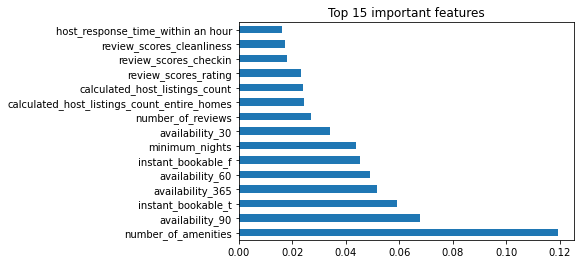

In [316]:
feat_importances = pd.Series(gridsearch2.best_estimator_[0].feature_importances_, index=df_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [206]:
rf_pipe2 = Pipeline([('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=1))
                    ])

In [207]:
rf_pipe2.fit(df_train,y_train)


Pipeline(steps=[('rf', RandomForestClassifier(max_depth=10, n_estimators=10))])

In [208]:
print_cv_scores(rf_pipe2, df_train, y_train)


[0.945425   0.94474789 0.94623996 0.94542746 0.94434414]
Training Accuracy 0.9452368888046273
##############
Cross_Val Accuracy 0.9452368888046273
##############
Training Precision: 0.9341623746299778
##############
Training  Recall: 0.056126246090695865
##############
Training  F1: 0.1054794954285863


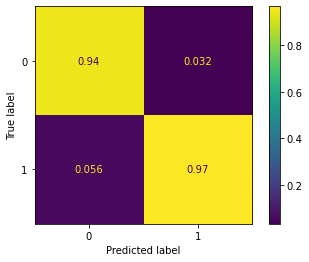

In [209]:
plot_confusion_matrix(rf_pipe2, df_train, y_train,normalize = 'pred');


In [258]:
rf_pipe3 = Pipeline([('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=1))
                    ])
rf_pipe3.fit(df_train,y_train)


Pipeline(steps=[('rf', RandomForestClassifier(max_depth=10, n_estimators=10))])

In [259]:
print_cv_scores(rf_pipe3, df_train, y_train)

[0.9473209  0.94650837 0.9448858  0.94479552 0.94614968]
Training Accuracy 0.94593205587504
##############
Cross_Val Accuracy 0.94593205587504
##############
Training Precision: 0.9383389074693422
##############
Training  Recall: 0.06863980648944487
##############
Training  F1: 0.1271607457712431


## RANDOM WITH SCALED

In [210]:
rf_pipe_scaled = Pipeline([('ss', StandardScaler()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=10))
                    ])
rf_pipe_scaled.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=10, n_estimators=10))])

In [211]:
print_cv_scores(rf_pipe_scaled, df_train, y_train)


[0.94646323 0.94614725 0.94466011 0.94623996 0.94506635]
Training Accuracy 0.9457153797100448
##############
Cross_Val Accuracy 0.9457153797100448
##############
Training Precision: 0.9276941132184099
##############
Training  Recall: 0.06551297400312743
##############
Training  F1: 0.12187350119247502


## RANDOM WITH SMOTE

In [212]:
rf_pipe_sm = imbpipe([('smote', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=10))
                    ])

rf_pipe_sm.fit(df_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('rf', RandomForestClassifier(max_depth=10, n_estimators=10))])

In [213]:
print_cv_scores(rf_pipe_sm, df_train, y_train)


[0.88931522 0.8922945  0.88494177 0.89238964 0.88692787]
Training Accuracy 0.8891737980474341
##############
Cross_Val Accuracy 0.8891737980474341
##############
Training Precision: 0.32459226640130084
##############
Training  Recall: 0.8497504153635653
##############
Training  F1: 0.4696715713347799


In [214]:
rf_pipe_sm2 = imbpipe([('smote', SMOTE()),
                    ('rf', RandomForestClassifier(max_depth=10, min_samples_leaf=1))
                    ])

rf_pipe_sm2.fit(df_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('rf', RandomForestClassifier(max_depth=10))])

In [215]:
print_cv_scores(rf_pipe_sm2, df_train, y_train)


[0.89062429 0.89364872 0.88792092 0.89369865 0.89433059]
Training Accuracy 0.892044635488042
##############
Cross_Val Accuracy 0.892044635488042
##############
Training Precision: 0.3323602251643762
##############
Training  Recall: 0.8613184128225176
##############
Training  F1: 0.4796018304999807


## RANDOM WITH SCALE AND SMOTE

In [216]:
rf_pipe_sm_sc = imbpipe([('ss', StandardScaler()),
                    ('smote', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=1))
                    ])

rf_pipe_sm_sc.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('rf', RandomForestClassifier(max_depth=10, n_estimators=10))])

In [217]:
print_cv_scores(rf_pipe_sm_sc,df_train, y_train )


[0.8716201  0.87812034 0.87609461 0.88133069 0.8820529 ]
Training Accuracy 0.8778437279086528
##############
Cross_Val Accuracy 0.8778437279086528
##############
Training Precision: 0.3092836917518566
##############
Training  Recall: 0.9033787382720876
##############
Training  F1: 0.46075645207792293


In [218]:
rf_pipe_sm_sc2 = imbpipe([('ss', StandardScaler()),
                    ('smote', SMOTE()),
                    ('rf', RandomForestClassifier())
                    ])

rf_pipe_sm_sc2.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('rf', RandomForestClassifier())])

In [219]:
print_cv_scores(rf_pipe_sm_sc2,df_train, y_train )


[1. 1. 1. 1. 1.]
Training Accuracy 1.0
##############
Cross_Val Accuracy 1.0
##############
Training Precision: 1.0
##############
Training  Recall: 1.0
##############
Training  F1: 1.0


In [246]:
rf_pipe_sm_sc3 = imbpipe([('ss', StandardScaler()),
                    ('smote', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=25, min_samples_leaf=1))
                    ])

rf_pipe_sm_sc3.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('rf', RandomForestClassifier(max_depth=25, n_estimators=10))])

In [247]:
print_cv_scores(rf_pipe_sm_sc3, df_train, y_train)

[0.97729427 0.97404415 0.97553489 0.97837862 0.97210436]
Training Accuracy 0.9754712588103203
##############
Cross_Val Accuracy 0.9754712588103203
##############
Training Precision: 0.7076162599387894
##############
Training  Recall: 0.9818632720875684
##############
Training  F1: 0.8223513250020952


## XGBOOST

In [220]:
xgb_pipe = Pipeline([('xgb', XGBClassifier(objective='binary:logistic',use_label_encoder=False, eval_metric='logloss'))
                    ])

In [221]:
xgb_pipe.fit(df_train,y_train)


Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [222]:
print_cv_scores(xgb_pipe, df_train, y_train)


[0.98203404 0.98207918 0.98212512 0.98068069 0.98031958]
Training Accuracy 0.9814477215239925
##############
Cross_Val Accuracy 0.9814477215239925
##############
Training Precision: 0.9626755863661508
##############
Training  Recall: 0.7060654075449568
##############
Training  F1: 0.8146321512246626


In [223]:
grid3 = {"xgb__max_depth": [10, 15, 20],
        "xgb__min_child_weight": [10, 25, 50], 
        "xgb__colsample_bytree" : [1, 2, 3, 4]
       
       
       }

gridsearch3 = GridSearchCV(xgb_pipe, grid3, return_train_score=True, scoring='precision',verbose=2)

In [224]:
gridsearch3.fit(df_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  14.0s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  13.5s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  13.2s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  13.5s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  13.2s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  12.9s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  12.5s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  12.3s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  14.9s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.45512603 0.47760325 0.48742386 0.44392104 0.4657689  0.49508436
 0.42770092 0.45060723 0.49508436        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the train scores are non-finite: [0.96375305 0.90082799 0.82604653 0.99201819 0.93911723 0.83474895
 0.99722704 0.94785937 0.83474895        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan     

GridSearchCV(estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      eval_metric='logloss',
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                      max_depth=6,
                                                      min

In [225]:
print('gridsearch best parameters: {}'.format(gridsearch3.best_params_))
print('gridsearch best score: {}'.format(gridsearch3.best_score_))


gridsearch best parameters: {'xgb__colsample_bytree': 1, 'xgb__max_depth': 15, 'xgb__min_child_weight': 50}
gridsearch best score: 0.49508436367477077


In [226]:
xgb_pipe2 = Pipeline([('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 15, min_child_weight= 50, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])


xgb_pipe2.fit(df_train, y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=15, min_child_weight=50, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [227]:
print_cv_scores(xgb_pipe2, df_train, y_train)


[0.9600957  0.96023112 0.96136138 0.96054889 0.95996208]
Training Accuracy 0.9604398332293765
##############
Cross_Val Accuracy 0.9604398332293765
##############
Training Precision: 0.8347489522354372
##############
Training  Recall: 0.3927448201720094
##############
Training  F1: 0.5341180231307922


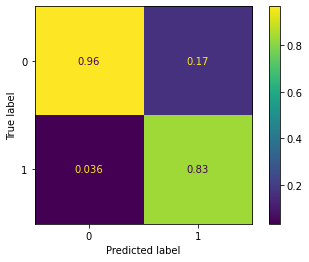

In [228]:
plot_confusion_matrix(xgb_pipe2, df_train, y_train, normalize = 'pred');


In [229]:
pd.DataFrame(xgb_pipe2.predict_proba(df_train)*100, columns=xgb_pipe2.classes_)


,0,1
0,98.825829,1.174170
1,99.831696,0.168306
2,99.938042,0.061958
3,99.940300,0.059701
4,99.902725,0.097276
...,...,...
27687,93.885300,6.114702
27688,99.948494,0.051505
27689,95.687805,4.312195
27690,99.760468,0.239532


In [230]:
xgb_sm_pipe = imbpipe([('smote', SMOTE()),
                        ('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 15, min_child_weight= 25, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])

xgb_sm_pipe.fit(df_train,y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=15, min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [231]:
print_cv_scores(xgb_sm_pipe,df_train,y_train)


[0.98185347 0.97941588 0.98212512 0.98072583 0.98063555]
Training Accuracy 0.9809511715207551
##############
Cross_Val Accuracy 0.9809511715207551
##############
Training Precision: 0.8740586031070684
##############
Training  Recall: 0.7829887851837373
##############
Training  F1: 0.8260088013872533


In [232]:
xgb_sm_pipe_sc = imbpipe([('ss', StandardScaler()),
                        ('smote', SMOTE()),
                        ('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 10, min_child_weight= 25, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])

xgb_sm_pipe_sc.fit(df_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosi

In [233]:
print_cv_scores(xgb_sm_pipe_sc,df_train,y_train)


[0.97616576 0.97661716 0.97562517 0.97666336 0.97643766]
Training Accuracy 0.9763018216386999
##############
Cross_Val Accuracy 0.9763018216386999
##############
Training Precision: 0.8720011258856287
##############
Training  Recall: 0.6910577111024239
##############
Training  F1: 0.7710394271994998


## Final model

In [253]:
rf_pipe2.score(df_test, y_test)


0.9426930993391832

In [254]:
y_pred = rf_pipe2.predict(df_test)


In [255]:
precision_score(y_test, y_pred)


0.8333333333333334

In [ ]:
plot_confusion_matrix(rf_pipe2, df_test, y_test, normalize = 'pred');
